In this exercise you will train a CNN on the FULL Cats-v-dogs dataset. 

This will require you doing a lot of data preprocessing because the dataset isn't split into training and validation for you.

# Data Preparation

In [1]:
import os
import zipfile
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image

from shutil import copyfile


## 1. Download and extract the data

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"
    

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-12-07 06:32:28--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 173.222.228.51, 2600:1409:12:1a1::e59, 2600:1409:12:194::e59
Connecting to download.microsoft.com (download.microsoft.com)|173.222.228.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   185MB/s    in 4.3s    

2020-12-07 06:32:32 (182 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
# check
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


## 2. Create directories for train-test dataset

In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')

    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')

    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')

    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

## 3. Split Source data to Train-Test data

In [5]:
def split_data(SOURCE_DIR, TRAINING_DIR, TESTING_DIR, split_size):
  # get elements of source dir as a list then shuffle
  fnames_shuffled = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))

  # clean -- copy only those with nonzero file length
  # filters out corrupted files
  fnames = []
  for fname in fnames_shuffled:
    if os.path.getsize(SOURCE_DIR + fname) != 0:
      fnames.append(fname)

  # split
  train_fnames = fnames[:int(len(fnames)*split_size)]
  test_fnames = fnames[int(len(fnames)*split_size):]


  # process transferring
  for fname in train_fnames:
    copyfile( SOURCE_DIR + fname, TRAINING_DIR + fname )
  
  for fname in test_fnames:
    copyfile( SOURCE_DIR + fname, TESTING_DIR + fname )


CAT_SOURCE_DIR = '/tmp/PetImages/Cat/'
TRAINING_CATS_DIR = '/tmp/cats-v-dogs/training/cats/'
TESTING_CATS_DIR = '/tmp/cats-v-dogs/testing/cats/'

DOG_SOURCE_DIR = '/tmp/PetImages/Dog/'
TRAINING_DOGS_DIR = '/tmp/cats-v-dogs/training/dogs/'
TESTING_DOGS_DIR = '/tmp/cats-v-dogs/testing/dogs/'


split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [6]:
# check and explore splitted data
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


## 4. Train and Valid ImageDataGenerator

In [7]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = image.ImageDataGenerator(rescale=1/255)

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=10,
    target_size=(150,150),
    class_mode="binary"
)

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = image.ImageDataGenerator(rescale=1/255)

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# VALIDATION GENERATOR.
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=10,
    target_size=(150,150),
    class_mode="binary"
)

# Expected Output:
# Found 2700 images belonging to 2 classes.
# Found 300 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Model

## 1. Build the model

Define a Keras Model to classify cats vs. dogs.
Use at least 3 convolution layers

In [8]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(150,150,3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

## 2. Compile the model

In [9]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(lr=0.001), metrics=["accuracy"])

## 3. Fit the model

In [10]:
history = model.fit_generator(
    train_generator,
    epochs=2,
    verbose=1,
    validation_data=validation_generator
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
 286/2250 [==>...........................] - ETA: 1:05 - loss: 0.7061 - accuracy: 0.5273

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

2250/2250 [==============================] - 82s 37ms/step - loss: 0.5948 - accuracy: 0.6796 - val_loss: 0.4924 - val_accuracy: 0.7548
Epoch 2/2
2250/2250 [==============================] - 82s 36ms/step - loss: 0.4986 - accuracy: 0.7692 - val_loss: 0.4718 - val_accuracy: 0.7776


## 4. Plot Loss and Accuracy

Desired output must be charts with non-crashing training and validation metrics.

Text(0.5, 1.0, 'Training and validation loss')

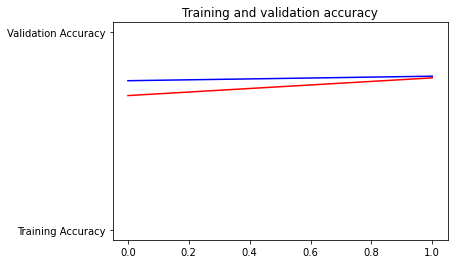

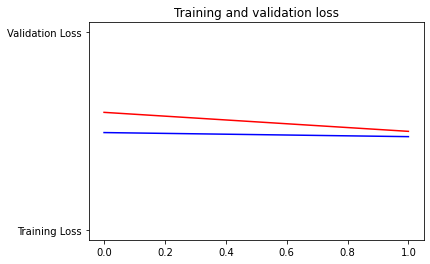

In [12]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)